In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import os
from skimage import io
from panoptes_client import Panoptes, Subject, Workflow
from dateutil.parser import parse
import tqdm
import subprocess
%matplotlib inline

In [3]:
data = ascii.read('reductions/question_reducer_jet_or_not.csv', format='csv')

# change the columns to make it easier to work with
data.rename_column('data.no-there-are-no-jets-in-this-image-sequence', 'data.no')
data.rename_column('data.yes-there-is-at-least-one-jet-in-this-image-sequence', 'data.yes')

# fill in missing data
data['data.yes'].fill_value = 0
data['data.no'].fill_value = 0
data = data.filled()

In [4]:
print(f"Number of subjects: {len(data)}")

Number of subjects: 6858


In [5]:
num_votes = np.asarray(data['data.no']) + np.asarray(data['data.yes'])
counts    = np.asarray(np.dstack([data['data.yes'], data['data.no']])[0])
most_likely  = np.argmax(counts, axis=1)

value_yes = most_likely==0
value_no  = most_likely==1

agreement = np.zeros_like(num_votes)

agreement[value_yes] = counts[value_yes,0]/(num_votes[value_yes])
agreement[value_no]  = counts[value_no,1]/(num_votes[value_no])

agreement = np.asarray(agreement)

Let's look at the observation times of subjects with jets. 

In [6]:
jet_mask = most_likely==0
jet_subjects = data['subject_id'][jet_mask]

print(len(jet_subjects))

2209


Now, we need to access the subject metadata. To make simple, I'm going to actually query from Panoptes, since the alternative involves parsing the dictionary from the `subject_data` column in the classification CSV. 

In [9]:
obs_time = []

for i, subject in enumerate(tqdm.tqdm(jet_subjects)):
    panoptes_subject = Subject(subject)
    
    # make sure that this is in the jet subject set
    if '100128' not in panoptes_subject.raw['links']['subject_sets']:
        continue
    
    # get the obsdate from the filename (format ssw_cutout_YYYYMMDD_HHMMSS_*.png). we'll strip out the 
    # extras and just get the date in ISO format and parse it into a datetime array
    obs_datestring = panoptes_subject.metadata['#file_name_0'].split('_')[2:4]
    obs_time.append(parse(f'{obs_datestring[0]}T{obs_datestring[1]}'))


100%|███████████████████████████████████████████████████████████████████████████████| 2209/2209 [03:37<00:00, 10.17it/s]


Do the same for non-jet subjects

In [11]:
obs_time_non_jet = []

non_jet_mask = most_likely==1
non_jet_subjects = data['subject_id'][non_jet_mask]

print(len(non_jet_subjects))

for i, subject in enumerate(tqdm.tqdm(non_jet_subjects)):
    panoptes_subject = Subject(subject)
    
    # make sure that this is in the jet subject set
    if '100128' in panoptes_subject.raw['links']['subject_sets']:
        continue
    
    # get the obsdate from the filename (format ssw_cutout_YYYYMMDD_HHMMSS_*.png). we'll strip out the 
    # extras and just get the date in ISO format and parse it into a datetime array
    obs_datestring = panoptes_subject.metadata['#file_name_0'].split('_')[2:4]
    obs_time_non_jet.append(parse(f'{obs_datestring[0]}T{obs_datestring[1]}'))


4649


100%|███████████████████████████████████████████████████████████████████████████████| 4649/4649 [07:12<00:00, 10.76it/s]


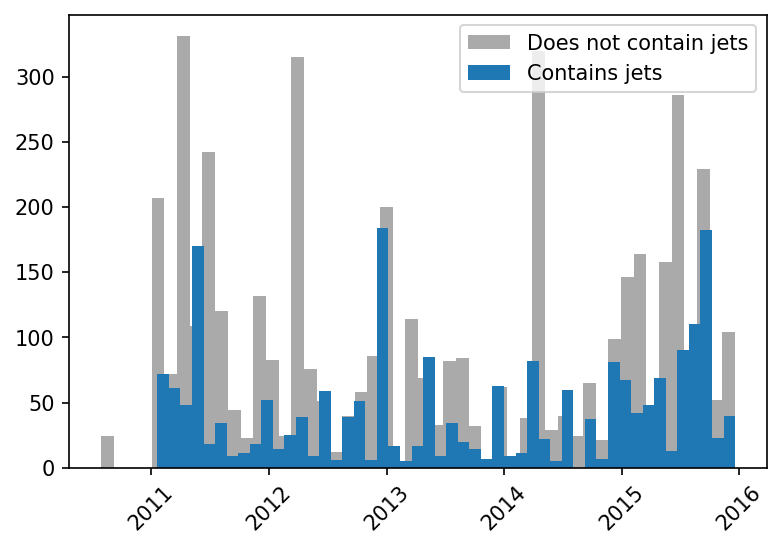

In [12]:
plt.figure(dpi=150, facecolor='white')
plt.hist(obs_time_non_jet, bins=50, color="#aaa", label="Does not contain jets")
plt.hist(obs_time, bins=50, label="Contains jets")
plt.xticks(rotation = 45) 

plt.legend(loc='upper right')

plt.show()